# CMSC320 Final Project


/tmp/ipython-input-245-3185631624.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])


(588, 10)

Column:  Index ----- Number of NaN:  0
Column:  Date ----- Number of NaN:  0
Column:  U.S. Airline Traffic - Total - Seasonally Adjusted ----- Number of NaN:  521
Column:  Transit Ridership - Other Transit Modes - Adjusted ----- Number of NaN:  336
Column:  Transit Ridership - Fixed Route Bus - Adjusted ----- Number of NaN:  336
Column:  Transit Ridership - Urban Rail - Adjusted ----- Number of NaN:  336
Column:  Highway Fuel Price - Regular Gasoline ----- Number of NaN:  200
Column:  Passenger Rail Passengers ----- Number of NaN:  16
Column:  Passenger Rail Total Train Miles ----- Number of NaN:  16
Column:  Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted ----- Number of NaN:  501
Total NaN:  2262
Gas Prices Missing:   0


([<matplotlib.patches.Wedge at 0x7e5d8c6a9310>,
 [Text(1.1, 0.0, 'Index'),
  Text(1.1, 0.0, 'Date'),
  Text(0.8243741046850103, 0.7282906943829421, 'U.S. Airline Traffic - Total - Seasonally Adjusted'),
  Text(-0.3699944872681613, 1.0359073700824657, 'Transit Ridership - Other Transit Modes - Adjusted'),
  Text(-1.0526621424527618, 0.3192215748453757, 'Transit Ridership - Fixed Route Bus - Adjusted'),
  Text(-0.8830445241143204, -0.6559210077682476, 'Transit Ridership - Urban Rail - Adjusted'),
  Text(-0.20503846027108075, -1.080721624568355, 'Highway Fuel Price - Regular Gasoline'),
  Text(0.12348622426552076, -1.0930467292923234, 'Passenger Rail Passengers'),
  Text(0.17192723597561965, -1.0864810286101565, 'Passenger Rail Total Train Miles'),
  Text(0.8442834033925634, -0.7051138452447734, 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted')],
 [Text(0.6, 0.0, '0%'),
  Text(0.6, 0.0, '0%'),
  Text(0.4496586025554601, 0.39724946966342295, '23

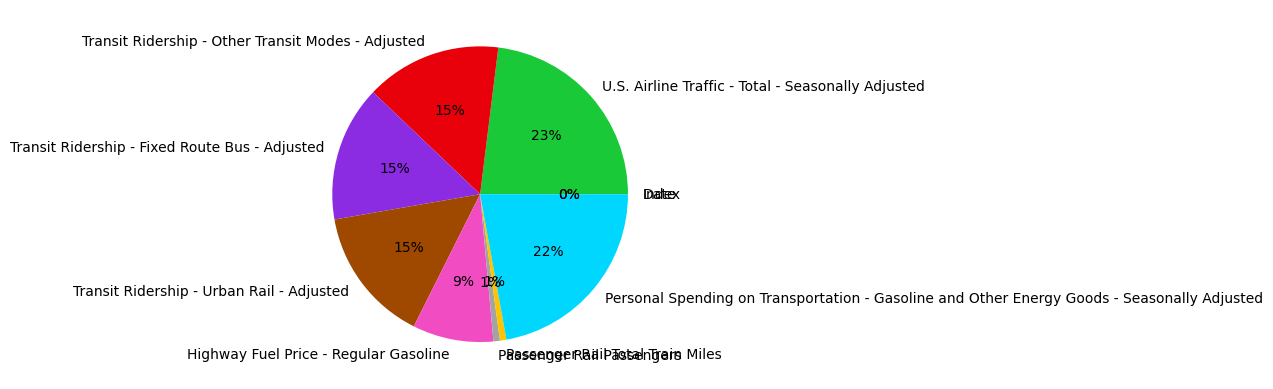

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

transportation_df = pd.read_csv('Monthly_Transportation_Statistics.csv')
gasprices_df = pd.read_csv('USGasanddieselprices.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
#print(list(transportation_df.columns))
transportation_df = transportation_df[['Index', 'Date', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']]
gasprices_df = gasprices_df[['Date', 'A1']]
#print(transportation_df.columns)
#print(gasprices_df.columns)
transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])
transportation_df = transportation_df.loc[transportation_df['Date'] >= '01-01-1975']
display(transportation_df.shape)


total_nan = 0
for curr in range(0, len(transportation_df.columns)):
    print("Column: ", transportation_df.columns[curr] , "----- Number of NaN: ", transportation_df.iloc[:, curr].isnull().sum())
    total_nan += transportation_df.iloc[:, curr].isnull().sum()

print('Total NaN: ', total_nan)
print('Gas Prices Missing:  ', gasprices_df.loc[:, 'A1'].isnull().sum())

#print(transportation_df.isna().sum())

colors = sns.color_palette('bright')[0:10]
plt.pie(x = transportation_df.isna().sum(), labels = transportation_df.isna().sum().index, colors = colors, autopct='%.0f%%')

#gasprices_df.head




We have two datasets, one is for transportation, another is for gas prices specifically. As the chart above demonstrates, there is a lot of data missing in the transportation dataframe especially from airline traffic and personal spending on transportation. Looking at the dataframes themselves, one can notice that for all missing data, the data is not missing after a certain date, meaning that the data is missing not at random (MNAR) because there is a clear time frame where the data is missing. In fact, none of the choosen columns have any data before 1975. The gas dataframe on the other hand, has no prices missing as we are using the "All Grades All Formulations Gasoline Prices" column only for simplicity.

In [246]:
gasprices_df.rename(columns={"A1": "Weekly Retail Gasoline Prices(All Grades Formulation)"}, inplace=True)
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])
display(gasprices_df.head())

,Date,Weekly Retail Gasoline Prices(All Grades Formulation)
0,1995-01-02,1.127
1,1995-01-09,1.134
2,1995-01-16,1.126
3,1995-01-23,1.132
4,1995-01-30,1.131


The only column used from the gas prices csv file was renamed from "A1" to "Weekly Retail Gasoline Prices(All Grades Formulation)" to indicate what the column values represent.
The purpose of renaming not only serves as an indicator to people who view the gas prices csv but it also helps in making it clear what is being predicted during the ML model phase
of this project.

In [247]:
# List only the data columns that can be NaN (exclude 'Index' and 'Date')
cols = [
    'U.S. Airline Traffic - Total - Seasonally Adjusted',
    'Transit Ridership - Other Transit Modes - Adjusted',
    'Transit Ridership - Fixed Route Bus - Adjusted',
    'Transit Ridership - Urban Rail - Adjusted',
    'Highway Fuel Price - Regular Gasoline',
    'Passenger Rail Passengers',
    'Passenger Rail Total Train Miles',
    'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted'
]
print(transportation_df[cols].isna().sum())
print(transportation_df.shape)
# Drop rows where all specified columns are NaN
transportation_df = transportation_df.dropna(subset=cols, how='all')
print(transportation_df[cols].isna().sum())
print(transportation_df.shape)



U.S. Airline Traffic - Total - Seasonally Adjusted                                             521
Transit Ridership - Other Transit Modes - Adjusted                                             336
Transit Ridership - Fixed Route Bus - Adjusted                                                 336
Transit Ridership - Urban Rail - Adjusted                                                      336
Highway Fuel Price - Regular Gasoline                                                          200
Passenger Rail Passengers                                                                       16
Passenger Rail Total Train Miles                                                                16
Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted    501
dtype: int64
(588, 10)
U.S. Airline Traffic - Total - Seasonally Adjusted                                             513
Transit Ridership - Other Transit Modes - Adjusted                                    

When looking at the three transit columns, it can be noticed that the data only exists from 2002 to the end of 2022, causing many nan. To solve this, we will create a seperate dataframe just with the three columns.

In [248]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
transit_df = transportation_df[[ 'Date','Transit Ridership - Other Transit Modes - Adjusted',
    'Transit Ridership - Fixed Route Bus - Adjusted',
    'Transit Ridership - Urban Rail - Adjusted']]

transit_df = transit_df.loc[ '2002-01-01' <= transit_df['Date'], :]
transit_df = transit_df.loc[ transit_df['Date'] <= '2022-12-01', :]
print(transit_df.isnull().sum())





Date                                                  0
Transit Ridership - Other Transit Modes - Adjusted    0
Transit Ridership - Fixed Route Bus - Adjusted        0
Transit Ridership - Urban Rail - Adjusted             0
dtype: int64


The dates for which all eight of those data columns are simultaneously missing will be dropped since they will not give us any information.

In [249]:
'''
either_missing = transportation_df.loc[
    transportation_df[rail_cols].isna().any(axis=1), 'Date'
]
print("Either rail column is NaN on:")
print(either_missing.dt.date.to_list())
df = transportation_df.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# The two columns you want to plot
rail_cols = [
    'Passenger Rail Passengers',
    'Passenger Rail Total Train Miles'
]

plt.figure()
for col in rail_cols:
    plt.plot(df.index, df[col], label=col)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Passenger Rail Usage Over Time')
plt.legend()
plt.tight_layout()
plt.show()
'''

rail_cols = [
    'Passenger Rail Passengers',
    'Passenger Rail Total Train Miles'
]
# Fill NaN values in the rail columns with forward and backward fill
transportation_df[rail_cols] = (transportation_df[rail_cols].ffill().bfill())
print(transportation_df[rail_cols].isna().sum())



Passenger Rail Passengers           0
Passenger Rail Total Train Miles    0
dtype: int64


/tmp/ipython-input-249-4095428837.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transportation_df[rail_cols] = (transportation_df[rail_cols].ffill().bfill())


Since the number of NaNs is only 8, we use the nearest value to imputate the NaNs for the above two fields.

In [250]:

col = 'Highway Fuel Price - Regular Gasoline'
'''
missing_hwy_dates = (
    transportation_df.loc[transportation_df[col].isna(), 'Date']
                     .sort_values()
                     .unique()
)


blocks = []
start = prev = missing_hwy_dates[0]
count = 1

for cur in missing_hwy_dates[1:]:
    if cur == prev + pd.DateOffset(months=1):
        prev = cur
        count += 1
    else:
        blocks.append((start.date(), prev.date(), count))
        start = prev = cur
        count = 1


blocks.append((start.date(), prev.date(), count))


for i, (bstart, bend, cnt) in enumerate(blocks, 1):
    print(f"Block {i}: from {bstart} through {bend}  ->  {cnt} months")'''

start, end = '1975-01-01', '1990-08-01'
c_hwy = (transportation_df['Date'] >= start) & (transportation_df['Date'] <= end)
df_pre1990 = transportation_df.loc[c_hwy].copy()
df_pre1990 = df_pre1990.dropna(axis=1, how='all')
print(df_pre1990.shape)
print("Remaining columns:", list(df_pre1990.columns))
print(df_pre1990.isna().sum())

(188, 4)
Remaining columns: ['Index', 'Date', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles']
Index                               0
Date                                0
Passenger Rail Passengers           0
Passenger Rail Total Train Miles    0
dtype: int64


Since most of the columns have all NaNs in from the period of 1975 to 1990, we create a seperate data (df_pre1990) frame during that time. Columns where all values are NaNs are dropeed and the other NaNs

In [251]:
cols = [
  'Transit Ridership - Other Transit Modes - Adjusted',
  'Transit Ridership - Fixed Route Bus - Adjusted',
  'Transit Ridership - Urban Rail - Adjusted'
]
mask_all = transportation_df[cols].isna().all(axis=1)
dates = transportation_df.loc[mask_all, 'Date'].sort_values().unique()
blocks = []
start = prev = dates[0]
for d in dates[1:]:
    if d == prev + pd.DateOffset(months=1):
        prev = d
    else:
        blocks.append((start, prev))
        start = prev = d
blocks.append((start, prev))
pd.set_option('display.max_rows', None)
#print(dates)
#print("Missing blocks:", blocks)

start, end = '1990-09-01', '2001-12-01'
mask = (transportation_df['Date'] >= start) & (transportation_df['Date'] <= end)
df_pre2002 = transportation_df.loc[mask].copy()

df_pre2002 = df_pre2002.dropna(axis=1, how='all')

print(df_pre2002.shape)
print("Remaining columns:", list(df_pre2002.columns))
df_pre2002 = df_pre2002.ffill().bfill()
#print(df_pre2002)
print(df_pre2002.isna().sum())

(136, 5)
Remaining columns: ['Index', 'Date', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles']
Index                                    0
Date                                     0
Highway Fuel Price - Regular Gasoline    0
Passenger Rail Passengers                0
Passenger Rail Total Train Miles         0
dtype: int64


All three transit‐ridership columns in transportation_df share the same missing‐value dates. In other words, none of these series exist before a common “start date.” Moreover, the NaNs are grouped from 1990-01-01 to 2001-12-01 and then from 2023-01-01 to 2023-07-01. Thus, we make a seperate data frame to analyse the data in this period. All the remaining NaNs are handled using imputation from the nearest neighbour.

In [252]:


start_mid, end_mid = '2002-01-01', '2016-12-01'

mask_mid = (transportation_df['Date'] >= start_mid) & (transportation_df['Date'] <= end_mid)
df_2002_2016 = transportation_df.loc[mask_mid].copy()

df_2002_2016 = df_2002_2016.dropna(axis=1, how='all')

print("Shape:", df_2002_2016.shape)
print("Columns remaining:", df_2002_2016.columns.tolist())
print(df_2002_2016.isna().sum())

Shape: (180, 9)
Columns remaining: ['Index', 'Date', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']
Index                                                                                            0
Date                                                                                             0
Transit Ridership - Other Transit Modes - Adjusted                                               0
Transit Ridership - Fixed Route Bus - Adjusted                                                   0
Transit Ridership - Urban Rail - Adjusted                                                        0
Highway Fuel Price - Regular Gasoline                                                            0
Pas

In [253]:

col = 'U.S. Airline Traffic - Total - Seasonally Adjusted'

missing_air_dates = (
    transportation_df.loc[transportation_df[col].isna(), 'Date']
                     .sort_values()
                     .unique()
)

# 2. Identify contiguous blocks and count their lengths
blocks = []
start = prev = missing_air_dates[0]
count = 1

for cur in missing_air_dates[1:]:
    if cur == prev + pd.DateOffset(months=1):
        prev = cur
        count += 1
    else:
        blocks.append((start.date(), prev.date(), count))
        start = prev = cur
        count = 1

# append the final block
blocks.append((start.date(), prev.date(), count))

# 3. Print every block with its month‐count
#for i, (bstart, bend, cnt) in enumerate(blocks, 1):
    #print(f"Block {i}: from {bstart} through {bend}  →  {cnt} months")

cutoff = '2016-12-01'

df_post2016 = transportation_df.loc[transportation_df['Date'] > cutoff].copy()

df_post2016 = df_post2016.dropna(axis=1, how='all')

df_post2016 = df_post2016.ffill().bfill()

print(df_post2016.shape)
print("Columns remaining:", df_post2016.columns.tolist())
display(df_post2016.head())
display(df_2002_2016.head())
display(df_pre2002.head())
display(df_pre1990.head())
#print(df_post2016.isna().sum())

(76, 10)
Columns remaining: ['Index', 'Date', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers', 'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']


,Index,Date,U.S. Airline Traffic - Total - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Passenger Rail Total Train Miles,Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted
840,840,2017-01-01,70190000.0,15695383.0,379032287.0,385406234.0,2.349,2330923.0,3432608.0,3.209980e+11
841,841,2017-02-01,69790000.0,15160465.0,373246708.0,367315442.0,2.304,2153891.0,3121837.0,3.209980e+11
842,842,2017-03-01,69680000.0,17507282.0,415647479.0,430111836.0,2.325,2659548.0,3464598.0,3.209980e+11
843,843,2017-04-01,70350000.0,17044306.0,388066756.0,407072908.0,2.417,2764389.0,3342228.0,3.260000e+11
844,844,2017-05-01,70720000.0,18539625.0,405517838.0,429163483.0,2.391,2822981.0,3487216.0,3.260000e+11


,Index,Date,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Passenger Rail Total Train Miles,Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted
660,660,2002-01-01,11117998.0,430318522.0,276530991.0,1.107,1759871.0,3449820.0,4.524630e+11
661,661,2002-02-01,10801941.0,414396657.0,260745192.0,1.114,1772163.0,3146083.0,NaN
662,662,2002-03-01,11444827.0,440766593.0,288404172.0,1.249,2021506.0,3474697.0,NaN
663,663,2002-04-01,11701049.0,438453423.0,292201780.0,1.397,2049477.0,3375089.0,4.567650e+11
664,664,2002-05-01,12019400.0,441175267.0,298698607.0,1.392,2114453.0,3544543.0,NaN


,Index,Date,Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Passenger Rail Total Train Miles
524,524,1990-09-01,1.258,3073787.0,3269824.0
525,525,1990-10-01,1.335,3291394.0,3613612.0
526,526,1990-11-01,1.324,3181611.0,3356131.0
527,527,1990-12-01,1.324,3023138.0,3395859.0
528,528,1991-01-01,1.324,3097361.0,3174949.0


,Index,Date,Passenger Rail Passengers,Passenger Rail Total Train Miles
336,336,1975-01-01,0.0,4134425.0
337,337,1975-02-01,0.0,3600736.0
338,338,1975-03-01,0.0,4067192.0
339,339,1975-04-01,0.0,4000157.0
340,340,1975-05-01,0.0,4050197.0


/tmp/ipython-input-254-475646135.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[flag_title] = (predictions == -1).astype(int)


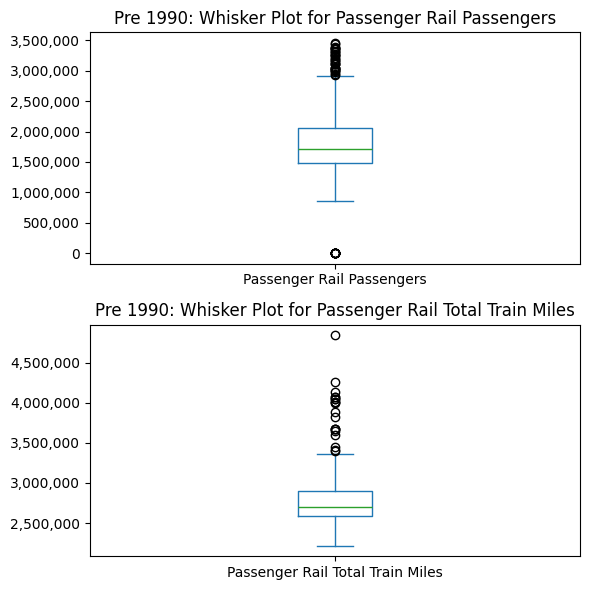


Pre 1990:


,Index,Date,Passenger Rail Passengers,Outliers Flagged Passenger Rail Passengers,Passenger Rail Total Train Miles,Outliers Flagged Passenger Rail Total Train Miles
336,336,1975-01-01,0.0,1,4134425.0,1
337,337,1975-02-01,0.0,1,3600736.0,1
338,338,1975-03-01,0.0,1,4067192.0,0
339,339,1975-04-01,0.0,1,4000157.0,1
340,340,1975-05-01,0.0,1,4050197.0,0


/tmp/ipython-input-254-475646135.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[flag_title] = (predictions == -1).astype(int)


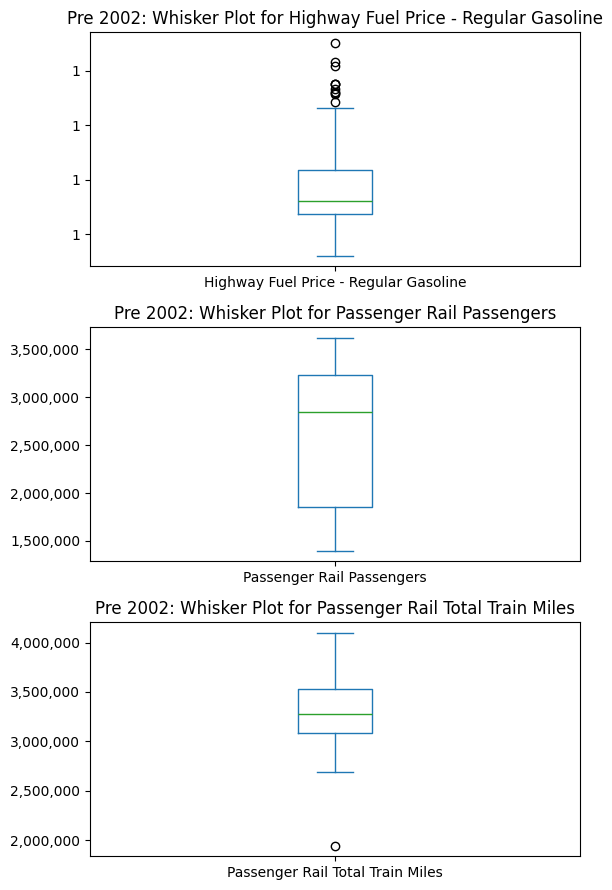


Pre 2002:


,Index,Date,Highway Fuel Price - Regular Gasoline,Outliers Flagged Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Outliers Flagged Passenger Rail Passengers,Passenger Rail Total Train Miles,Outliers Flagged Passenger Rail Total Train Miles
524,524,1990-09-01,1.258,0,3073787.0,0,3269824.0,0
525,525,1990-10-01,1.335,1,3291394.0,0,3613612.0,0
526,526,1990-11-01,1.324,0,3181611.0,0,3356131.0,0
527,527,1990-12-01,1.324,0,3023138.0,0,3395859.0,0
528,528,1991-01-01,1.324,0,3097361.0,0,3174949.0,0


/tmp/ipython-input-254-475646135.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[flag_title] = (predictions == -1).astype(int)


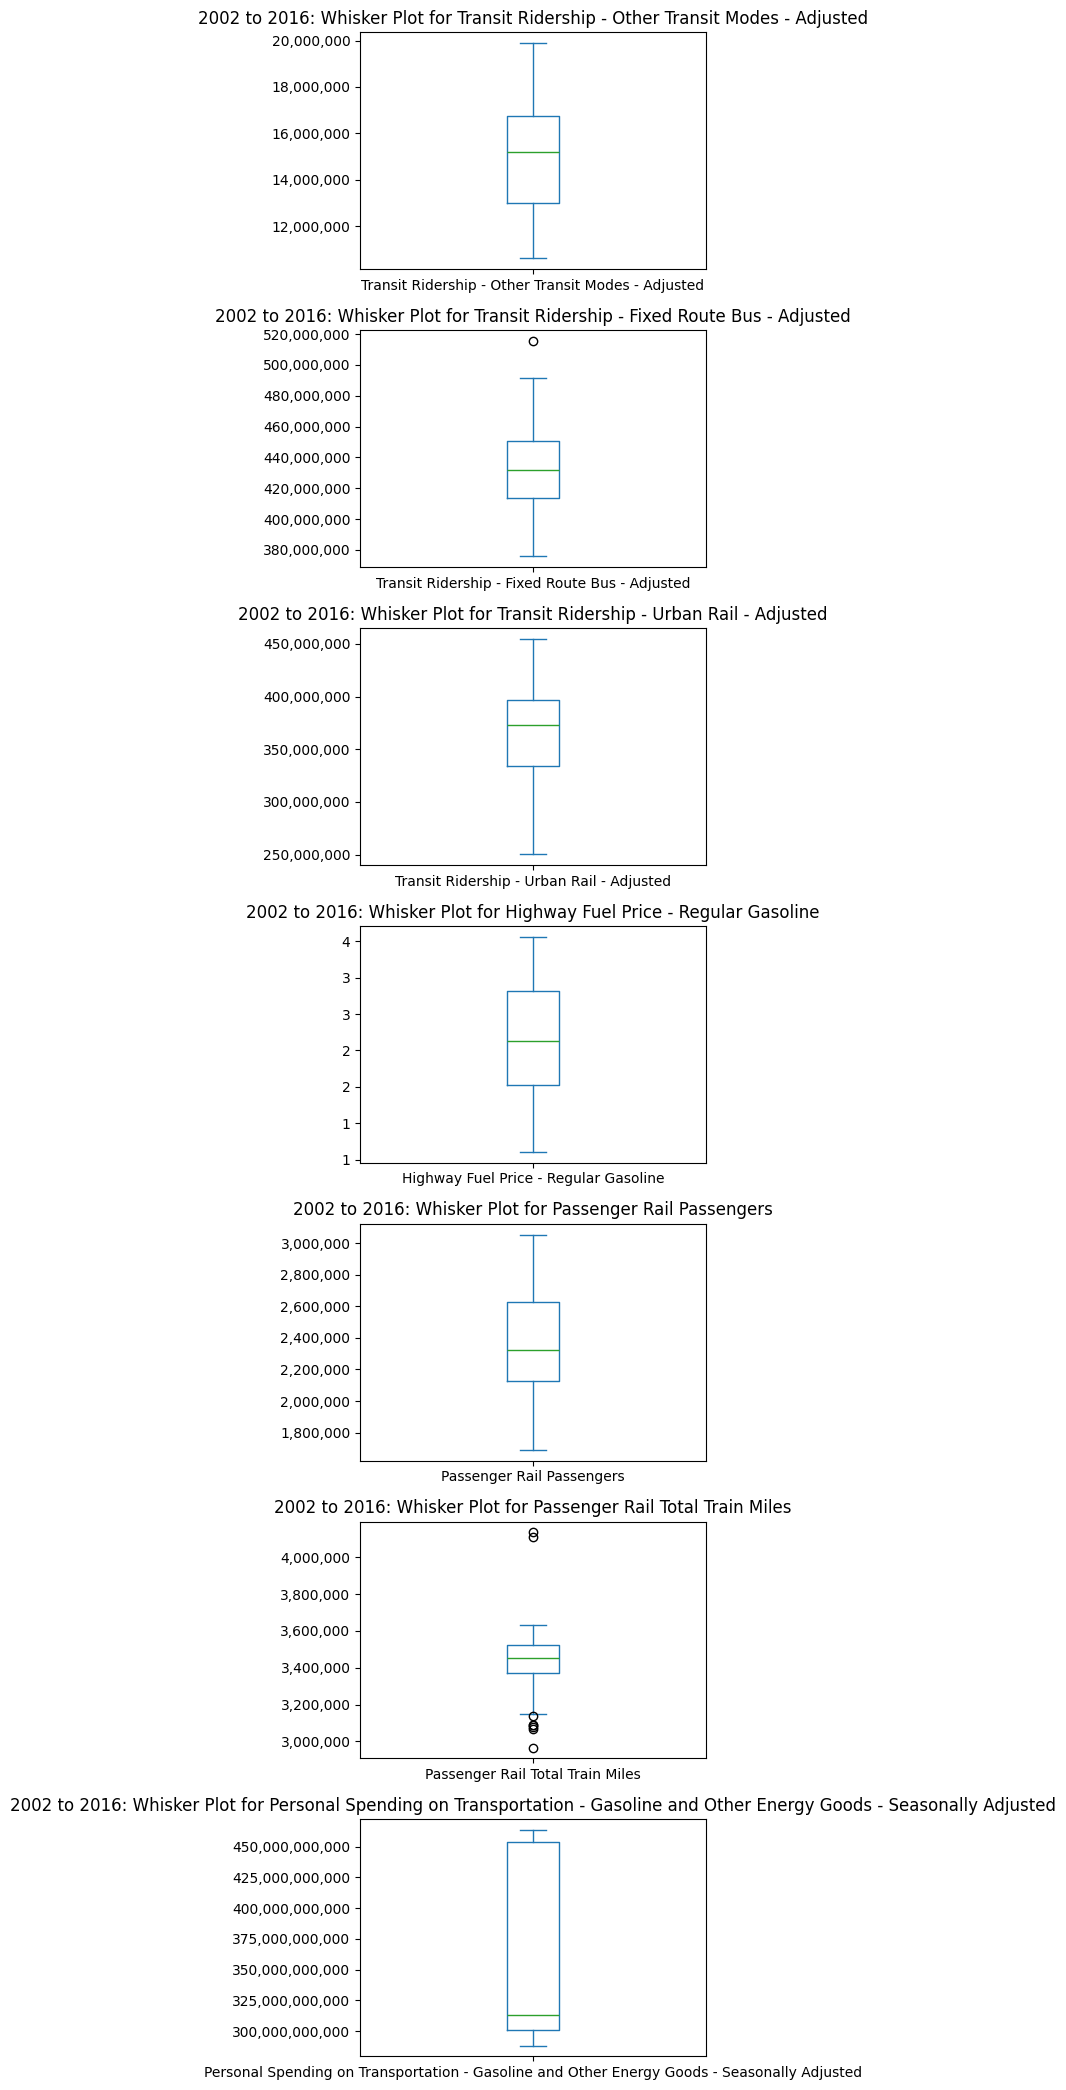


2002 to 2016:


,Index,Date,Transit Ridership - Other Transit Modes - Adjusted,Outliers Flagged Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Outliers Flagged Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Outliers Flagged Transit Ridership - Urban Rail - Adjusted,Highway Fuel Price - Regular Gasoline,Outliers Flagged Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Outliers Flagged Passenger Rail Passengers,Passenger Rail Total Train Miles,Outliers Flagged Passenger Rail Total Train Miles,Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted,Outliers Flagged Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted
660,660,2002-01-01,11117998.0,1,430318522.0,0,276530991.0,0,1.107,1,1759871.0,1,3449820.0,0,4.524630e+11,0
661,661,2002-02-01,10801941.0,1,414396657.0,0,260745192.0,1,1.114,1,1772163.0,1,3146083.0,1,NaN,0
662,662,2002-03-01,11444827.0,0,440766593.0,0,288404172.0,0,1.249,1,2021506.0,0,3474697.0,0,NaN,0
663,663,2002-04-01,11701049.0,0,438453423.0,0,292201780.0,1,1.397,0,2049477.0,0,3375089.0,0,4.567650e+11,0
664,664,2002-05-01,12019400.0,0,441175267.0,0,298698607.0,0,1.392,0,2114453.0,0,3544543.0,0,NaN,0


/tmp/ipython-input-254-475646135.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[flag_title] = (predictions == -1).astype(int)


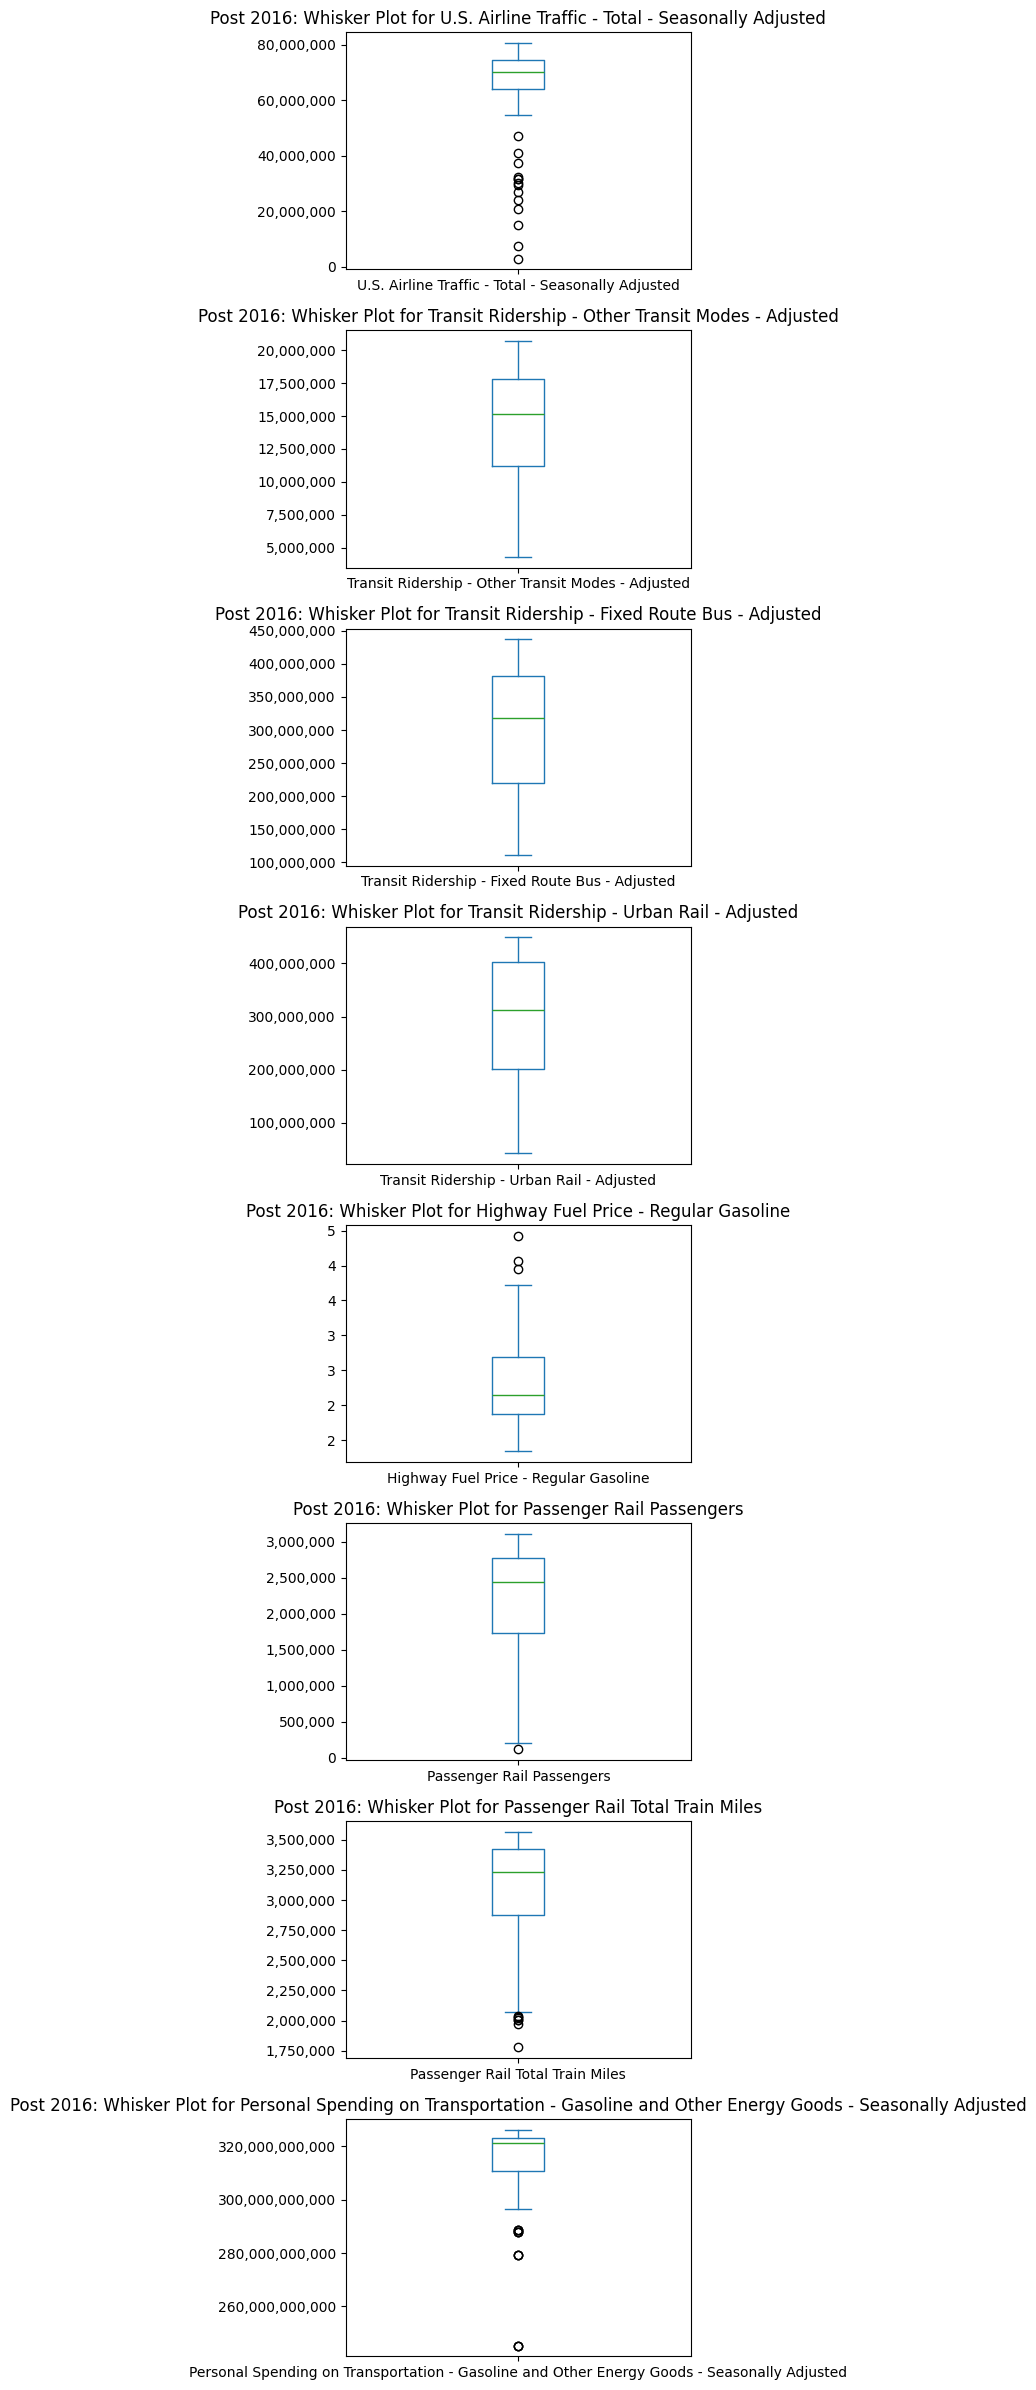


Post 2016:


,Index,Date,U.S. Airline Traffic - Total - Seasonally Adjusted,Outliers Flagged U.S. Airline Traffic - Total - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Outliers Flagged Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Outliers Flagged Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Outliers Flagged Transit Ridership - Urban Rail - Adjusted,Highway Fuel Price - Regular Gasoline,Outliers Flagged Highway Fuel Price - Regular Gasoline,Passenger Rail Passengers,Outliers Flagged Passenger Rail Passengers,Passenger Rail Total Train Miles,Outliers Flagged Passenger Rail Total Train Miles,Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted,Outliers Flagged Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted
840,840,2017-01-01,70190000.0,0,15695383.0,0,379032287.0,0,385406234.0,0,2.349,0,2330923.0,0,3432608.0,0,3.209980e+11,0
841,841,2017-02-01,69790000.0,0,15160465.0,0,373246708.0,0,367315442.0,0,2.304,0,2153891.0,0,3121837.0,0,3.209980e+11,0
842,842,2017-03-01,69680000.0,0,17507282.0,0,415647479.0,1,430111836.0,0,2.325,0,2659548.0,0,3464598.0,0,3.209980e+11,0
843,843,2017-04-01,70350000.0,0,17044306.0,0,388066756.0,0,407072908.0,0,2.417,0,2764389.0,0,3342228.0,0,3.260000e+11,0
844,844,2017-05-01,70720000.0,0,18539625.0,0,405517838.0,0,429163483.0,0,2.391,0,2822981.0,0,3487216.0,0,3.260000e+11,0


In [254]:
df_list = [df_pre1990, df_pre2002, df_2002_2016, df_post2016]
df_names = ["Pre 1990", "Pre 2002", "2002 to 2016", "Post 2016"]
updated_dfs = []
for df_name, df in zip(df_names, df_list):

  columns_plot = [col for col in df.columns[2:] if isinstance(col, str) and not col.startswith("Outliers")]

  fig, axes = plt.subplots(nrows=len(columns_plot), ncols=1, figsize=(6,3 * len(columns_plot)))
  if len(columns_plot)==1:
    axes = [axes]

  for ax, column in zip(axes,columns_plot):
    df[column].plot.box(ax=ax)
    ax.set_title(f"{df_name}: Whisker Plot for {column}")
    ax.ticklabel_format(style="plain", axis="y")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _:  f"{int(x):,}"))

    #Added Isolation Forest for Outlier Detection
    iso_forest = IsolationForest(contamination=0.1, random_state=43)
    predictions = iso_forest.fit_predict(df[[column]])

    flag_title = f"Outliers Flagged {column}"
    df[flag_title] = (predictions == -1).astype(int)
    columns = list(df.columns)
    if flag_title in columns:
      columns.remove(flag_title)
      index = columns.index(column)
      columns.insert(index + 1, flag_title)
      df = df[columns]





  plt.tight_layout()
  plt.show()

  print(f"\n{df_name}:")
  display(df.head())
  updated_dfs.append(df)

df_pre1990, df_pre2002, df_2002_2016, df_post2016 = updated_dfs

I identified the outliers for each column of each dataframe and then flagged the outliers by using IsolationForest. Then the outliers were displayed in their own respective flagging columns that are placed to the right of the columns each flagging column corresponds with. The outliers are given a one while non outliers are given the default zero.

The purpose of flagging outliers is so that we can currently obtain information on what are the extreme values in each respective era. When we eventually train our Machine Learning model we can make it account for whether a values was an outlier or not in that respective era. Then the model will be able to take all the outliers and rank them on what was the most extreme compared to all eras for that column. With this information we will be able to determine what was time period or even year was considered an anomaly when compared to other eras. Determining on a global level what is considered an anomaly based on the value's extremity is crucial for the model. This is because our primary objective is to be able to make future predictions on how gas prices impact rail usage and employment. Knowing whether an extreme value is an anomaly or part of a trend can help the model accurately predict the future pattern of gas prices impact on rail usage and employment.

Hypothesis Testing 1:

Null Hypothesis: There is no difference between the amount of rail passengers and the amount of bus passengers
Alternative Hypothesis: There are significantly more bus passengers than rail passengers

Test used: T-Test

In [255]:
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu

#print(transit_df.columns)
#df_2002_2016.iloc[:, [4, 6]]
print(stats.ttest_ind(transit_df.iloc[:, [2]], df_2002_2016.iloc[:, [ 3]]))

stats, pval = mannwhitneyu(df_2002_2016.iloc[:, [2]], df_2002_2016.iloc[:, [ 3]])
print("P-value for mann-whitney U: ", pval)

TtestResult(statistic=array([66.27472152]), pvalue=array([7.95144335e-228]), df=array([430.]))
P-value for mann-whitney U:  [2.14106936e-66]


Since the p-value returned is greater than .05, we fail to reject the null hypothesis

(252, 4)


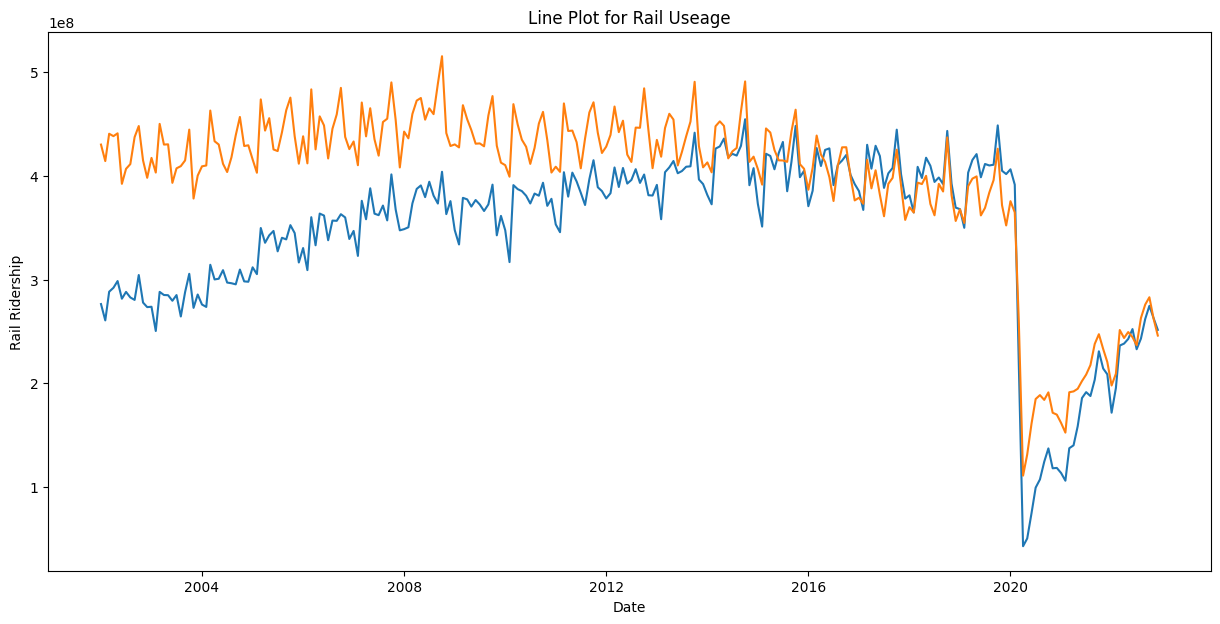

In [256]:
import matplotlib.pyplot as plt

print(transit_df.shape)
plt.figure(figsize=(15,7))

plt.plot(transit_df['Date'], transit_df['Transit Ridership - Urban Rail - Adjusted'])
plt.plot(transit_df['Date'], transit_df['Transit Ridership - Fixed Route Bus - Adjusted'])

plt.xlabel('Date')
plt.ylabel('Rail Ridership')

plt.title('Line Plot for Rail Useage')
plt.show()

Hypothesis Testing 2:


At a significance level of 95 %, alpha = 0.05

Null Hypothesis: There is no difference in Transit ridership when the gas prices are low/medium/high.


Alternative Hypthesis: There is a difference between transit ridership when the gas prices are low/medium/high.

In [257]:
gasprices_b_df = pd.read_csv('USGasanddieselprices.csv')
gasprices_b_df['Date'] = pd.to_datetime(gasprices_b_df['Date'])
gasprices_b_df = gasprices_b_df[gasprices_b_df['Date'] >= '2002-01-01']
gasprices_b_df = gasprices_b_df[['Date','A1']]
gasprices_b_df

transportation_b_df = pd.read_csv('Monthly_Transportation_Statistics.csv')
transportation_b_df = transportation_df[['Index', 'Date', 'U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted']]
transportation_b_df['Date'] = pd.to_datetime(transportation_b_df['Date'])
transportation_b_df = transportation_b_df.loc[transportation_df['Date'] >= '2002-01-01']

In [258]:
gasprices_month_df = gasprices_b_df.groupby(pd.Grouper( key = 'Date', freq = 'ME')).agg({'A1': 'mean'}).reset_index()
low_gasprices = gasprices_month_df[gasprices_month_df['A1'] < 2]
medium_gasprices = gasprices_month_df[(gasprices_month_df['A1'] >= 2) & (gasprices_month_df['A1'] <= 3)]
high_gasprices = gasprices_month_df[gasprices_month_df['A1'] > 3]

low_gasprice = low_gasprices.copy()
medium_gasprice = medium_gasprices.copy()
high_gasprice = high_gasprices.copy()

total_transit_ridership = transportation_b_df[['Date', 'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Urban Rail - Adjusted']]
total_transit_ridership['Total Transit Ridership'] = total_transit_ridership[['Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Urban Rail - Adjusted']].sum(axis = 1)
total_transit_ridership = total_transit_ridership.drop(total_transit_ridership[['Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Urban Rail - Adjusted']], axis = 1)
total_transit_ridership['YearMonth'] = total_transit_ridership['Date'].dt.strftime('%Y-%m') #yyyy-mm
low_gasprices['YearMonth'] = low_gasprices['Date'].dt.strftime('%Y-%m')
medium_gasprices['YearMonth'] = medium_gasprices['Date'].dt.strftime('%Y-%m')
high_gasprices['YearMonth'] = high_gasprices['Date'].dt.strftime('%Y-%m')

low_merge = pd.merge(low_gasprices, total_transit_ridership, on = 'YearMonth', how = 'inner')
medium_merge = pd.merge(medium_gasprices, total_transit_ridership, on = 'YearMonth', how = 'inner')
high_merge = pd.merge(high_gasprices, total_transit_ridership, on = 'YearMonth', how = 'inner')

low_riders = low_merge['Total Transit Ridership']
medium_riders = medium_merge['Total Transit Ridership']
high_riders = high_merge['Total Transit Ridership']

#ANOVA Test
f_stat, p_val = f_oneway(low_riders, medium_riders, high_riders)
print(f"ANOVA Test results: \nF =  {f_stat:.2f}, p = {p_val:.2f}\n\n\n")

ANOVA Test results: 
F =  20.89, p = 0.00





/tmp/ipython-input-258-1466652471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_transit_ridership['Total Transit Ridership'] = total_transit_ridership[['Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Urban Rail - Adjusted']].sum(axis = 1)
/tmp/ipython-input-258-1466652471.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_gasprices['YearMonth'] = low_gasprices['Date'].dt.strftime('%Y-%m')
/tmp/ipython-input-258-1

The p-value is less than our alpha which is 0.05.  p = 0 <= alpha = 0.05, therefore we reject the null hypthesis.

hT 3

In [259]:
all_ridership = pd.concat([
    low_merge['Total Transit Ridership'],
    medium_merge['Total Transit Ridership'],
    high_merge['Total Transit Ridership']
])

group_labels = (
    ['Low'] * len(low_merge) +
    ['Medium'] * len(medium_merge) +
    ['High'] * len(high_merge)
)

tukey_result = pairwise_tukeyhsd(endog=all_ridership, groups=group_labels, alpha=0.05)

# Print the result
print(tukey_result)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
group1 group2     meandiff    p-adj       lower          upper      reject
--------------------------------------------------------------------------
  High    Low -151298527.1984    0.0 -206924794.5128  -95672259.884   True
  High Medium  -70757132.7143 0.0003 -113212923.1892 -28301342.2393   True
   Low Medium   80541394.4841 0.0005   30606935.1027 130475853.8655   True
--------------------------------------------------------------------------


/tmp/ipython-input-260-2441858054.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(transportation_columns))  # or 'tab20'


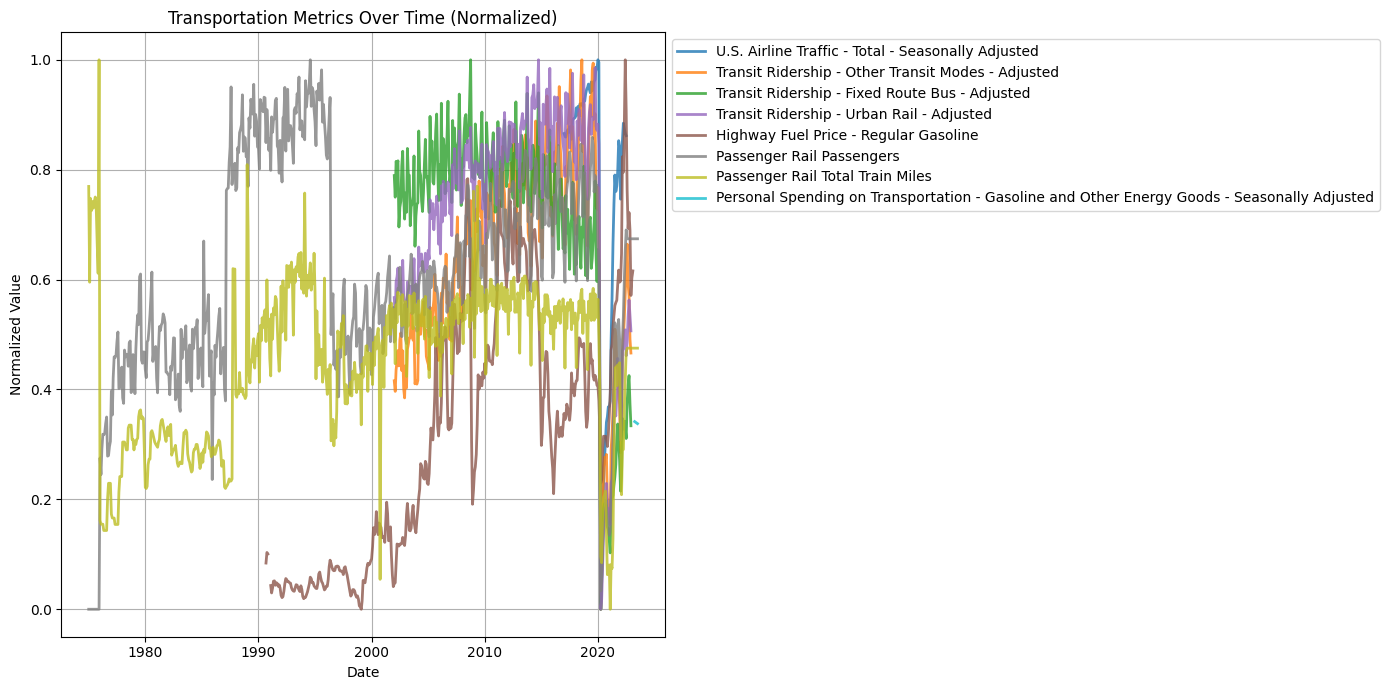

In [260]:
transportation_b_df = transportation_b_df[transportation_b_df['Date'] >= '2002-01-01']

transportation_columns = ['U.S. Airline Traffic - Total - Seasonally Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted',
'Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Urban Rail - Adjusted', 'Highway Fuel Price - Regular Gasoline', 'Passenger Rail Passengers',
'Passenger Rail Total Train Miles', 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted'

]

for col in transportation_columns:
    transportation_df[col] = pd.to_numeric(transportation_df[col], errors='coerce')


scaler = MinMaxScaler()
transportation_df[transportation_columns] = scaler.fit_transform(transportation_df[transportation_columns])

plt.figure(figsize=(14, 7))
colors = plt.cm.get_cmap('tab10', len(transportation_columns))  # or 'tab20'

for i, col in enumerate(transportation_columns):
    plt.plot(transportation_df['Date'], transportation_df[col], label=col, color=colors(i), linewidth=2, alpha=0.8)

plt.title("Transportation Metrics Over Time (Normalized)")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

As you can see the multiple graphs overlapping each other making it unrecognizable. As such, dropping columns such as Personal Spending on Transportation and Highway Fuel Price can be dropped. Since we already have a

/tmp/ipython-input-261-599374261.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transportation_avg_df[col] = pd.to_numeric(transportation_avg_df[col], errors='coerce')
/tmp/ipython-input-261-599374261.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(transportation_avg_columns))  # or 'tab20'


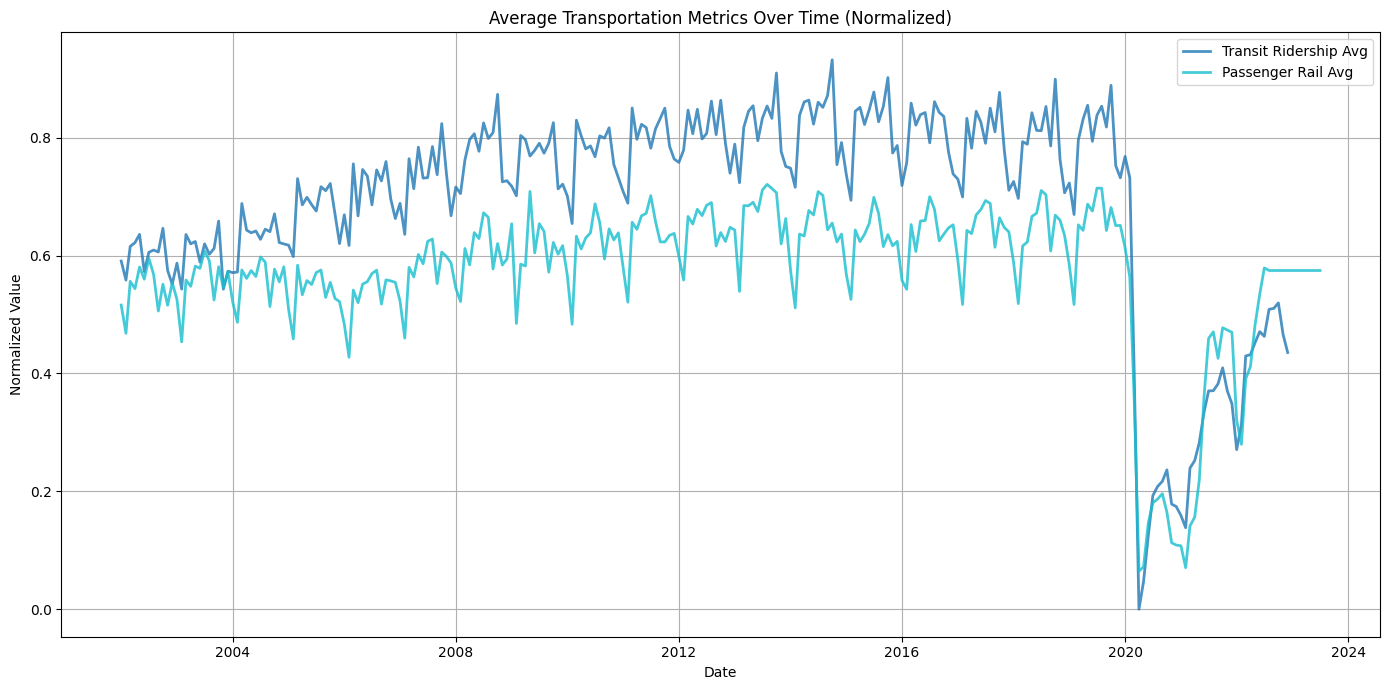

In [261]:
transportation_df['Transit Ridership Avg'] = transportation_df[['Transit Ridership - Fixed Route Bus - Adjusted', 'Transit Ridership - Other Transit Modes - Adjusted', 'Transit Ridership - Urban Rail - Adjusted']].mean(axis = 1)
transportation_df['Passenger Rail Avg'] = transportation_df[['Passenger Rail Passengers', 'Passenger Rail Total Train Miles']].mean(axis = 1)
transportation_df['Date'] = pd.to_datetime(transportation_df['Date'])
transportation_df = transportation_df[transportation_df['Date'] >= '2002-01-01']
transportation_avg_df = transportation_df[['Date', 'Transit Ridership Avg', 'Passenger Rail Avg']]
transportation_avg_columns = ['Transit Ridership Avg','Passenger Rail Avg',]

for col in transportation_avg_columns:
    transportation_avg_df[col] = pd.to_numeric(transportation_avg_df[col], errors='coerce')

#\\\transportation_avg_df[transportation_avg_columns] = scaler.fit_transform(transportation_avg_df[transportation_avg_columns])

plt.figure(figsize=(14, 7))
colors = plt.cm.get_cmap('tab10', len(transportation_avg_columns))  # or 'tab20'

for i, col in enumerate(transportation_avg_columns):
    plt.plot(transportation_avg_df['Date'], transportation_avg_df[col], label=col, color=colors(i), linewidth=2, alpha=0.8)

plt.title("Average Transportation Metrics Over Time (Normalized)")
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

Combined columns regarding tarnsit into one by taking their average. Same is done for passengers on rail. This was done to reduce the number of plots in total and to get a general idea of transit and passengers on rail. All other columns are left as original. For both dataframes, intersection of the core of data begins from 2002. Hence, both dataframe's timeline begins at 2002.In addition, normalization allows for both dataframes to be compared and to improve visualization.

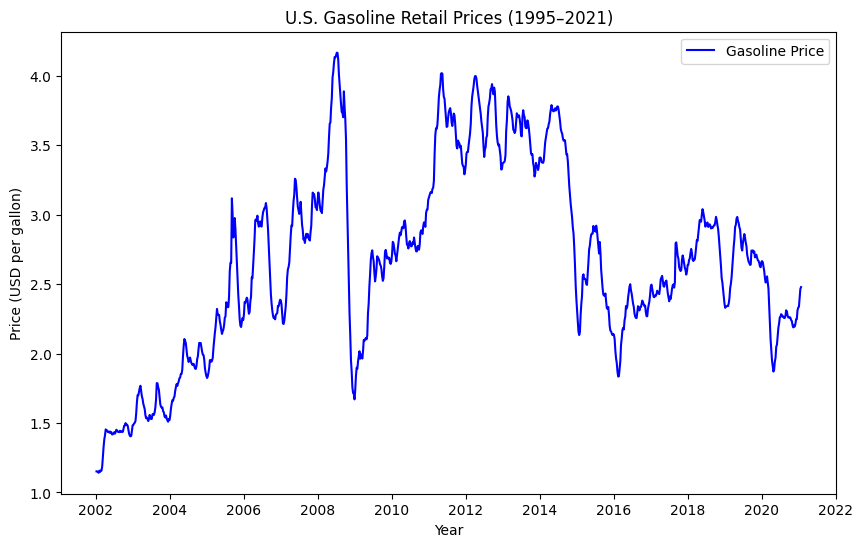

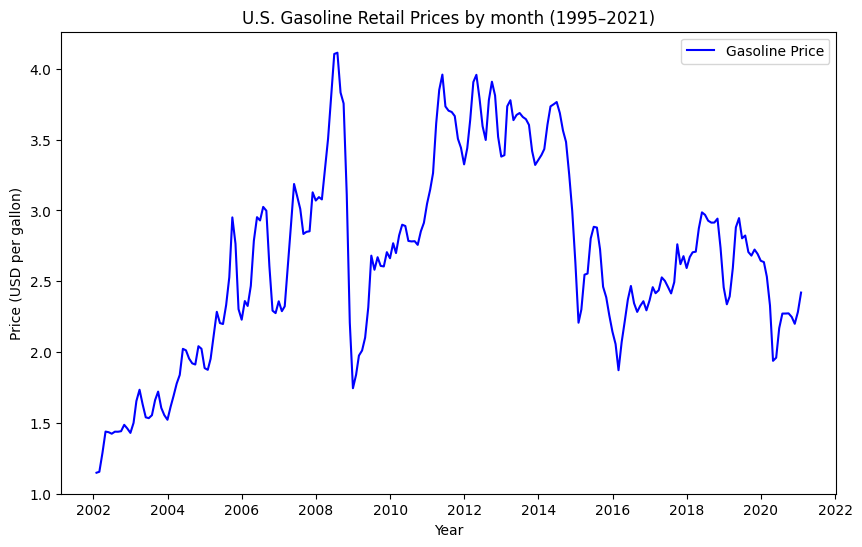

In [262]:
gasprices_df['Date'] = pd.to_datetime(gasprices_df['Date'])
gasprices_df = gasprices_df[gasprices_df['Date'] >= '2002-01-01']

#gasprices_df['A1_normalized'] = scaler.fit_transform(gasprices_df[['A1']])
plt.figure(figsize=(10, 6))
plt.plot(gasprices_b_df['Date'], gasprices_b_df['A1'], label='Gasoline Price', color='blue')
plt.title('U.S. Gasoline Retail Prices (1995–2021)')
plt.xlabel('Year')
plt.ylabel('Price (USD per gallon)')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(gasprices_month_df['Date'], gasprices_month_df['A1'], label='Gasoline Price', color='blue')
plt.title('U.S. Gasoline Retail Prices by month (1995–2021)')
plt.xlabel('Year')
plt.ylabel('Price (USD per gallon)')
plt.legend()